# SIAMESE ARCHITECTURE

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd "/content/drive/MyDrive/CI/"
!pip install import-ipynb

/content/drive/.shortcut-targets-by-id/1fPndHe31Mko5g75JKSEcrswLjQvUYExS/CI
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=f42dbf55dbfbc92eabbaf6384c108201d87b53e2c0a9f1245d33f2297481c647
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
import import_ipynb
import utility
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)
from tensorflow import keras
from tensorflow.keras import models,layers, Model
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
 


data_path='/content/drive/MyDrive/CI/numpy_data/'

# check hardware acceleration
device_name = tf.test.gpu_device_name()
print('GPU: ', device_name)

importing Jupyter notebook from utility.ipynb
Tensorflow Version: 2.4.1
GPU:  /device:GPU:0


In [ ]:
NORMALIZATION_VALUE = 65536

## Assign Correct Labels (Mass vs Calcification)

In this cells, we organized the images in a list of pairs.
Each pair is composed by:
- the baseline
- the correspondent abnormality 

We removed from the array of labels the baseline label and we change the classes:
- 1 and 2 became 0
- 3 and 4 became 4

## Load Training Set

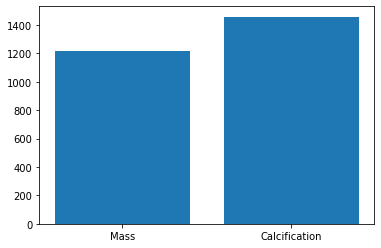

Oversampling must be done on 240 elements of the first array.
Class 0: 1458
Class 1: 1458


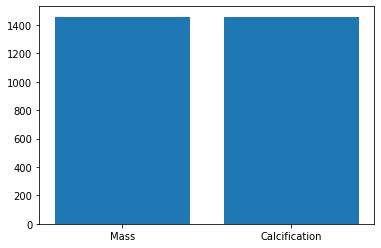

(2332, 2, 150, 150)
(584, 2, 150, 150)


In [ ]:
images, labels = utility.load_training()

images = images/NORMALIZATION_VALUE

training_set, training_labels = utility.make_pairs(images, labels)

class_0 = len([labels for label in training_labels if label == 0])
class_1 = len([labels for label in training_labels if label == 1])

plt.bar(['Mass', 'Calcification'], [class_0, class_1])
plt.title = 'Class Balancing'
plt.show()

training_set, training_labels = utility.oversample(training_set, training_labels)

class_0 = len([labels for label in training_labels if label == 0])
class_1 = len([labels for label in training_labels if label == 1])

plt.bar(['Mass', 'Calcification'], [class_0, class_1])
plt.title = 'Class Balancing after oversampling'
plt.show()

val_split = 0.2
X_train, X_val, y_train, y_val = train_test_split(training_set, training_labels, test_size=val_split, stratify=training_labels)

print(np.shape(X_train))
print(np.shape(X_val))

## Load Test Set

In [ ]:
images, labels = utility.load_test()

images = images/NORMALIZATION_VALUE

test_set, test_labels = utility.make_pairs(images, labels)

## Create Model

In [ ]:
INPUT_SHAPE = (150,150,1)
BATCH_SIZE = 32
LEARNING_RATE = 0.001

In [ ]:
def create_base_model(input_shape):
    model_input = layers.Input(shape=input_shape)
    #data_aug = layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=123)(model_input)
    data_aug = layers.experimental.preprocessing.RandomRotation(factor=0.25, seed=123, fill_mode='nearest')(model_input)
    embedding = layers.Conv2D(32, (3, 3), input_shape=input_shape, activation='relu')(data_aug)
    embedding = layers.MaxPooling2D((2, 2))(embedding)
    embedding = layers.Conv2D(64, (3, 3), activation='relu')(embedding)
    embedding = layers.MaxPooling2D((2, 2))(embedding)
    embedding = layers.Conv2D(128, (3, 3), activation='relu')(embedding)
    embedding = layers.MaxPooling2D((2, 2))(embedding)
    embedding = layers.Conv2D(128, (3, 3), activation='relu')(embedding)
    embedding = layers.MaxPooling2D((2, 2))(embedding)
    embedding = layers.Flatten()(embedding)
    embedding = layers.Dense(512, activation='relu')(embedding)
    return Model(model_input, embedding, name='Siamese')

In [ ]:
imgA = layers.Input(name='Baseline', shape=INPUT_SHAPE)
imgB = layers.Input(name='Abnormality', shape=INPUT_SHAPE)

siamese_model = create_base_model(INPUT_SHAPE)

#siamese_model.summary()

features_a = siamese_model(imgA)
features_b = siamese_model(imgB)

concatenation = layers.Concatenate(name='Concatenation')([features_a, features_b])
dropout = layers.Dropout(0.4)(concatenation)
dense = layers.Dense(512, activation='relu')(dropout)
sigmoid = layers.Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[imgA, imgB], outputs=sigmoid, name='Siamese-Network')

model.summary()

Model: "Siamese-Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Baseline (InputLayer)           [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
Abnormality (InputLayer)        [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
Siamese (Functional)            (None, 512)          3452032     Baseline[0][0]                   
                                                                 Abnormality[0][0]                
__________________________________________________________________________________________________
Concatenation (Concatenate)     (None, 1024)         0           Siamese[0][0]      

In [ ]:
opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics= ['accuracy'])

In [ ]:
history = model.fit(
    [X_train[:,0], X_train[:,1]],
    y_train[:],
    validation_data=([X_val[:,0], X_val[:,1]], y_val[:]),
    batch_size = BATCH_SIZE,
    epochs = 50
)

In [ ]:
utility.plot_history(history)

In [ ]:
dir_name ="/content/drive/MyDrive/CI/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name,'MC_SIAMESE.h5'))

In [ ]:
test_loss, test_accuracy = model.evaluate(
    x=[test_set[:,0], test_set[:,1]],
    y=test_labels,
    batch_size=BATCH_SIZE
)

print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

In [ ]:
from sklearn import metrics

test_predictions = model.predict(
    x=[test_set[:,0], test_set[:,1]],
    batch_size=BATCH_SIZE
)

results = utility.do_evaluations(test_predictions, test_labels)